# Colima Seperate GS Inversion

In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display(raw_df.head())

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
16,VF00-04a,1499,1506,625.8,60,19,31,18,11,6,2,1,1,1,"2,124.86"
18,VF00-06a3,1957,1997,417.2,40,7,30,25,17,11,5,1,1,1,"2,796.04"
17,VF00-05a3,1787,2173,500.64,48,10,30,24,16,9,3,1,1,1,"2,813.41"
37,VF06-03/5-09,-770,3082,594.51,57,11,25,25,19,11,4,1,1,1,"3,176.73"
31,VF05-08a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,1,1,"3,568.48"


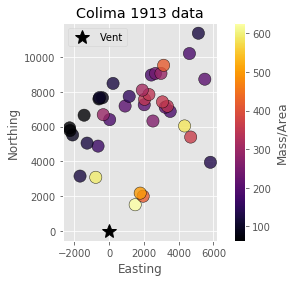

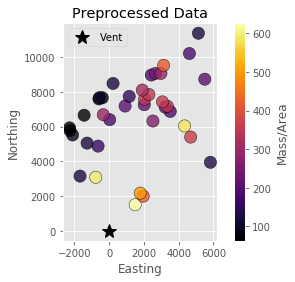

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values*100

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,0,732.73,23.1529,25.4668,22.2407,15.7304,8.99492,3.44384,0.823464,0.136596,0.0103587,"2,124.86",117.087
18,1957,1997,0,691.154,21.3541,24.7682,22.4602,16.5434,9.82586,3.90198,0.968656,0.164832,0.0128943,"2,796.04",165.665
17,1787,2173,0,709.841,21.2137,24.71,22.4801,16.6062,9.88889,3.93999,0.980849,0.16722,0.013114,"2,813.41",141.787
37,-770,3082,0,301.066,13.8022,19.2173,22.1297,20.4626,14.7247,7.12663,2.10569,0.398324,0.0329064,"3,176.73",50.641
31,-1673,3152,0,149.68,9.51561,14.8613,20.3208,22.2637,18.4942,10.3172,3.45994,0.706562,0.0606982,"3,568.48",119.591


In [5]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]*100

display(t2_const_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,2500,"1,394.46",17.2005,24.2121,24.7779,18.9162,10.8457,3.58293,0.449327,0.015328,2.84769e-05,"2,124.86",222.828
18,1957,1997,2500,"1,216.15",14.016,22.3619,24.864,20.2838,12.7356,4.93885,0.76913,0.0307052,6.30498e-05,"2,796.04",291.503
17,1787,2173,2500,"1,251",13.877,22.2837,24.8861,20.3522,12.8046,4.98427,0.780754,0.0313104,6.44789e-05,"2,813.41",249.88
37,-770,3082,2500,359.399,14.8025,22.8299,24.5313,19.4545,12.2828,5.13528,0.922533,0.0410962,9.09858e-05,"3,176.73",60.453
31,-1673,3152,2500,134.301,15.3664,23.3283,24.4813,18.8191,11.7036,5.16746,1.07907,0.054478,0.000131905,"3,568.48",107.303


In [6]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,"1,024","[-5,-4)",-5,0.0683375,-4
1,-3.5,"1,024","[-4,-3)",-4,0.109203,-3
2,-2.5,"1,024","[-3,-2)",-3,0.146694,-2
3,-1.5,"1,024","[-2,-1)",-2,0.16565,-1
4,-0.5,"1,024","[-1,0)",-1,0.157243,0
5,0.5,"1,233.5","[0,1)",0,0.125474,1
6,1.5,"1,443","[1,2)",1,0.0841661,2
7,2.5,"1,652.5","[2,3)",2,0.0474595,3
8,3.5,"1,862","[3,4)",3,0.0224962,4


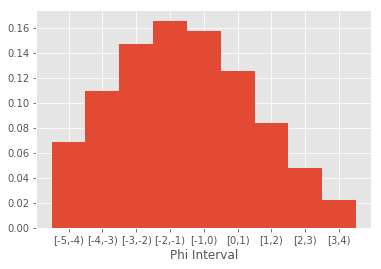

In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [8]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values*100
display(forward_df.head())

Forward Sim time: 0.03125 seconds
Dataframe Merge time: 0.03125 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.01562 seconds
Total time: 0.07812 seconds


,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,17.0237,24.0587,24.7461,19.0106,10.9865,3.68062,0.476505,0.0172657,3.63504e-05,"1,316.8","2,124.86",210.419
1,1997,1957,13.849,22.1879,24.803,20.3647,12.8847,5.06294,0.813217,0.0344694,8.0275e-05,"1,148.99","2,796.04",275.405
2,2173,1787,13.8004,22.2099,24.865,20.38,12.8556,5.04311,0.811521,0.0345019,8.06424e-05,"1,166.99","2,813.41",233.099
3,3082,-770,15.5611,23.6747,24.9019,19.0596,11.4484,4.52251,0.794749,0.0368917,9.33995e-05,300.905,"3,176.73",50.6139
4,3152,-1673,16.2556,24.3211,24.9428,18.4296,10.7682,4.36764,0.869463,0.0453801,0.000126158,111.015,"3,568.48",88.6983


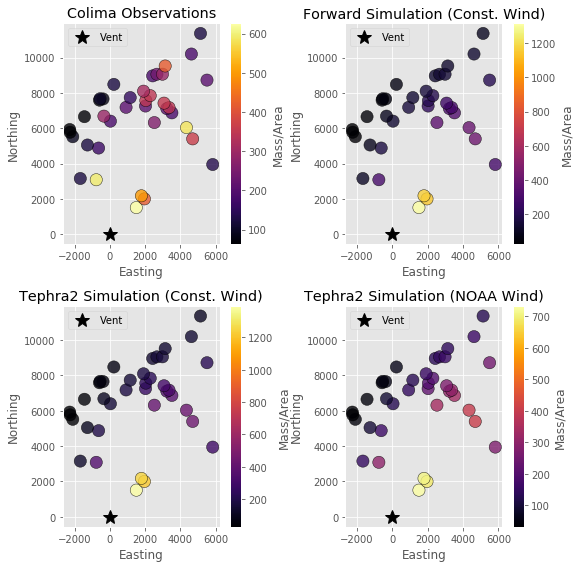

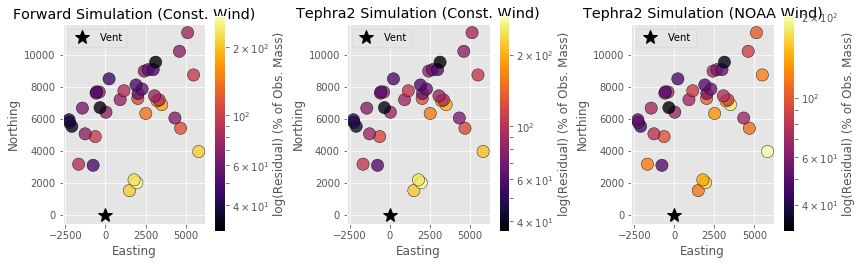

In [9]:
fig, axs = plt.subplots(2,2, figsize=(
        8,8), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[3])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
            title="Forward Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[2])




plt.tight_layout()
plt.show()

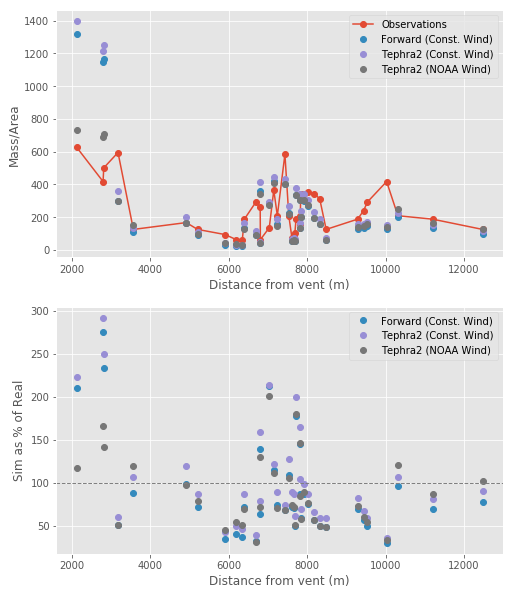

In [10]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========[-5,-4)========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:430: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = -3.31019	b* = -2.99440	            h1* = -0.49920	u* = -0.38244	v* = 3.41951	            D* = 8.29804	ftt* = 8.77307	TM* = 22.04730
a = 1.03651	b = 1.05007	            h1 = 5776.50000	u = 0.68219	v = 30.55438	            D = 4016.00000	ftt = 6458.00000	TM = 3758564623.12040
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 603
SSE: 2.2188897234253613


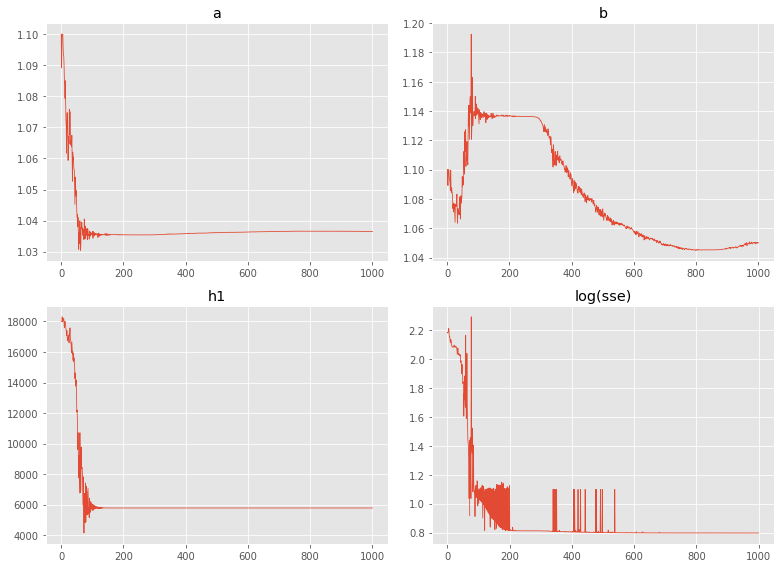

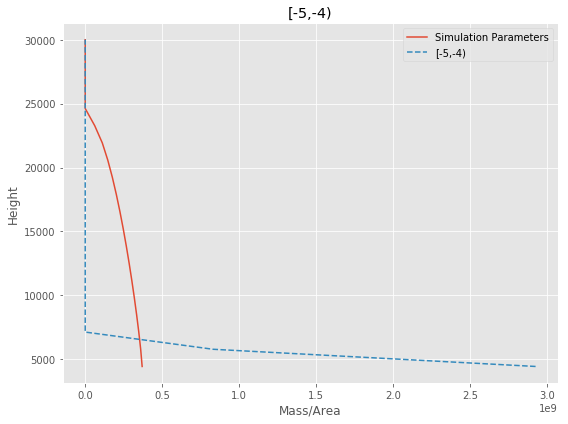

[-5,-4) Run Time: 0.19297 minutes


========[-4,-3)========
a* = 0.21246	b* = 0.17154	            h1* = -0.36322	u* = 0.50621	v* = 3.38830	            D* = 8.29804	ftt* = 8.77307	TM* = 22.51605
a = 2.23671	b = 2.18713	            h1 = 7122.40221	u = 1.65900	v = 29.61557	            D = 4016.00000	ftt = 6458.00000	TM = 6006169166.09182
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 614
SSE: 14.977773177413056


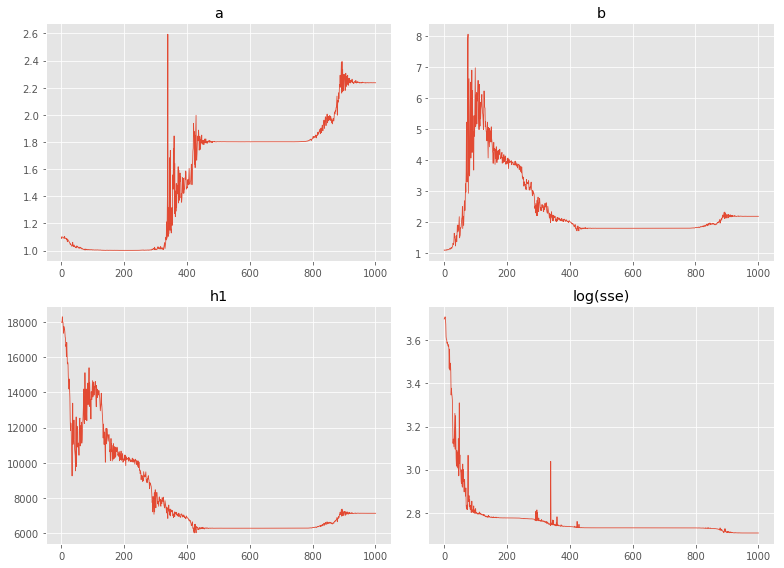

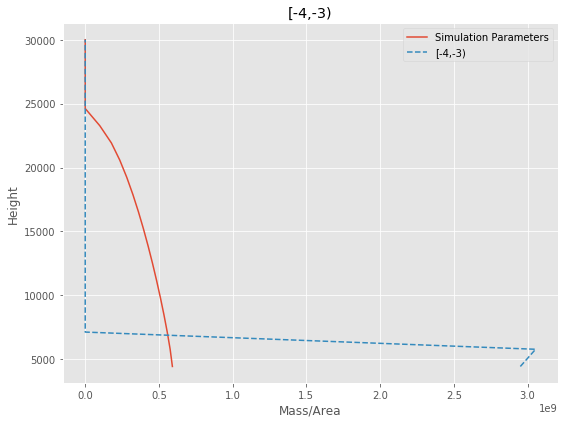

[-4,-3) Run Time: 0.18594 minutes


========[-3,-2)========
a* = -0.00973	b* = -2.24709	            h1* = 0.81077	u* = 1.52876	v* = 2.27843	            D* = 8.29804	ftt* = 8.77307	TM* = 22.81119
a = 1.99032	b = 1.10571	            h1 = 19234.00025	u = 4.61246	v = 9.76134	            D = 4016.00000	ftt = 6458.00000	TM = 8068164622.31213
Success: True, Optimization terminated successfully.
Iterations: 276
SSE: 17.721290243894476


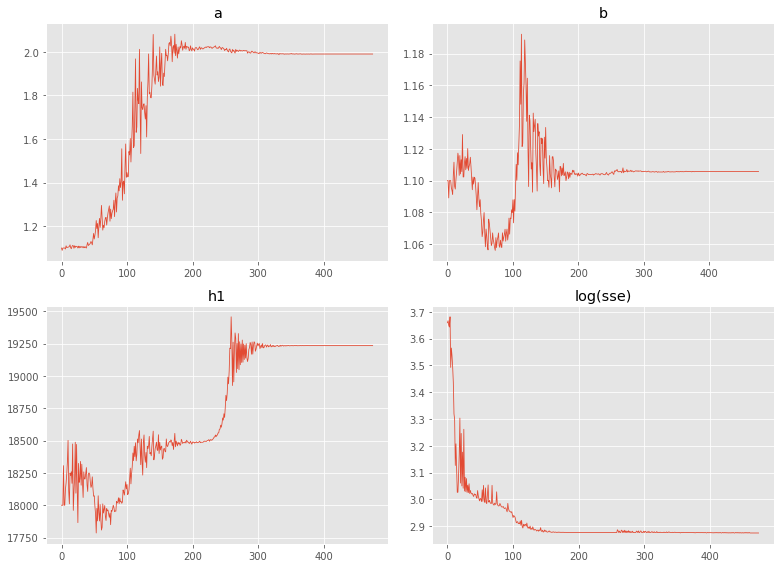

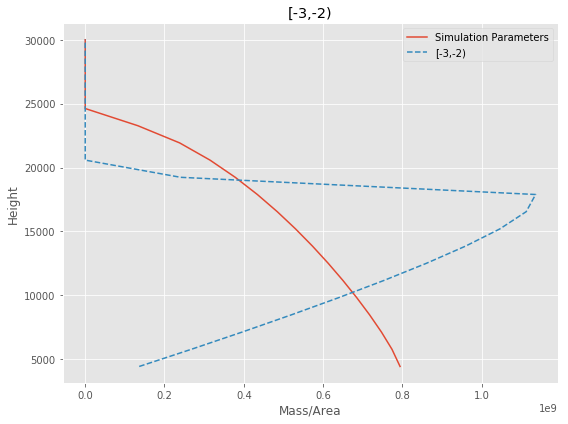

[-3,-2) Run Time: 0.09297 minutes


========[-2,-1)========
a* = -0.05591	b* = -2.35390	            h1* = 3.25796	u* = 1.46764	v* = 1.97796	            D* = 8.29804	ftt* = 8.77307	TM* = 22.93272
a = 1.94562	b = 1.09500	            h1 = 28867.91513	u = 4.33900	v = 7.22800	            D = 4016.00000	ftt = 6458.00000	TM = 9110738766.61036
Success: True, Optimization terminated successfully.
Iterations: 409
SSE: 11.991202515904899


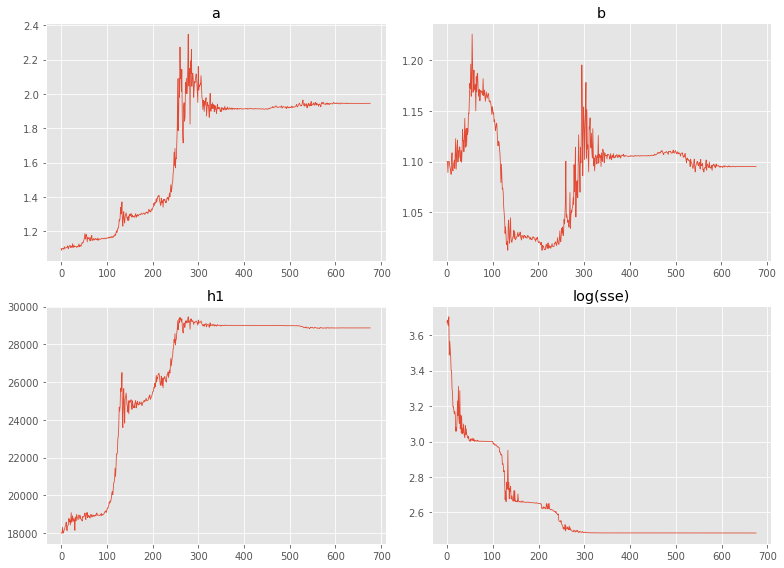

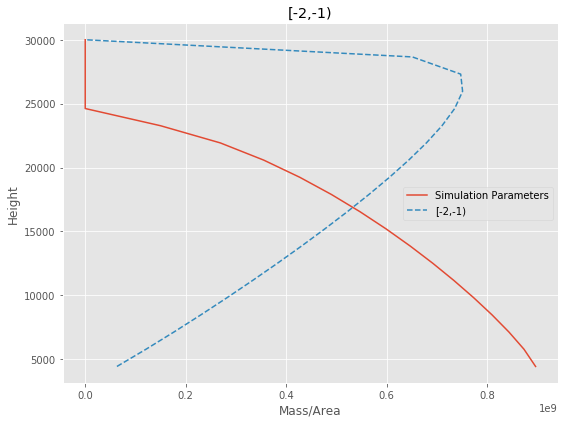

[-2,-1) Run Time: 0.13125 minutes


========[-1,0)========
a* = 0.18963	b* = -2.25574	            h1* = 0.38549	u* = 1.54355	v* = 2.51792	            D* = 8.29804	ftt* = 8.77307	TM* = 22.88064
a = 2.20881	b = 1.10480	            h1 = 15196.75034	u = 4.68117	v = 12.40283	            D = 4016.00000	ftt = 6458.00000	TM = 8648366582.16271
Success: True, Optimization terminated successfully.
Iterations: 257
SSE: 10.551366378945897


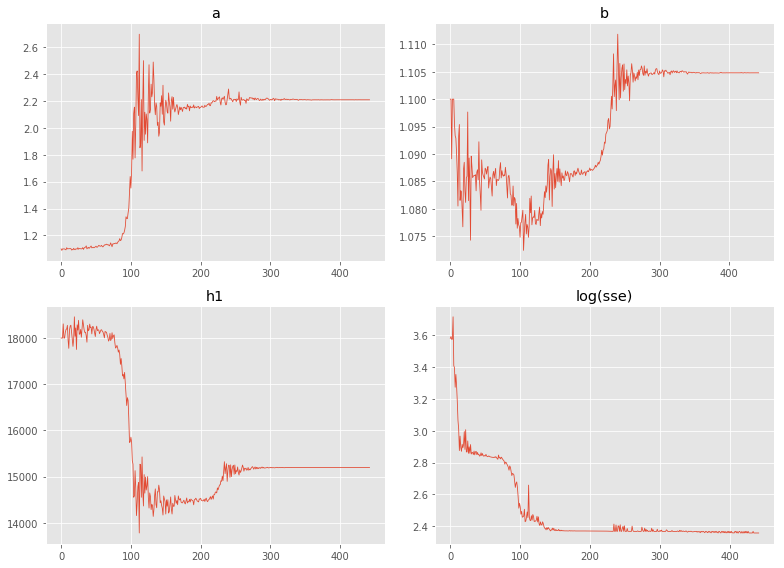

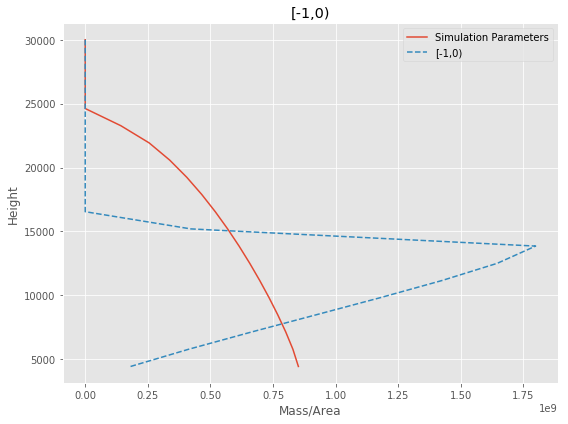

[-1,0) Run Time: 0.08776 minutes


========[0,1)========
a* = 1.44515	b* = -4.42894	            h1* = 0.01116	u* = 1.24009	v* = 2.41899	            D* = 8.29804	ftt* = 8.77307	TM* = 22.65494
a = 5.24247	b = 1.01193	            h1 = 11159.49427	u = 3.45592	v = 11.23451	            D = 4016.00000	ftt = 6458.00000	TM = 6901066909.64173
Success: True, Optimization terminated successfully.
Iterations: 347
SSE: 3.436334291507212


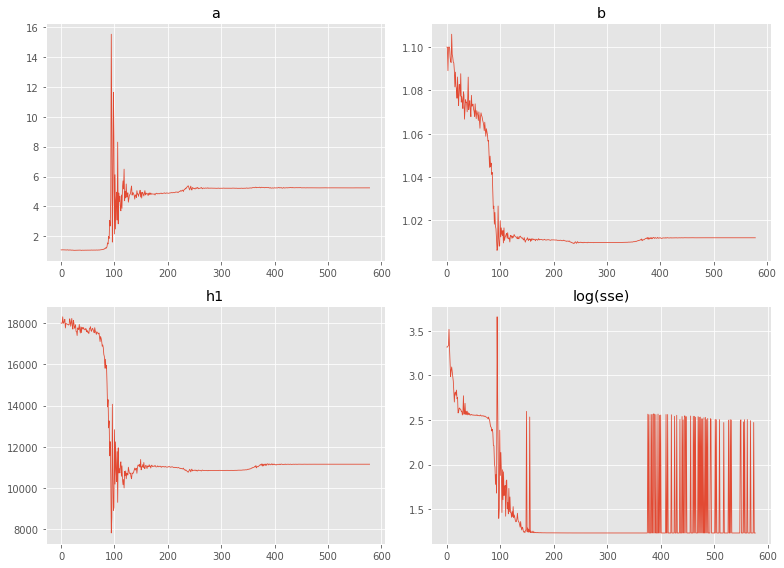

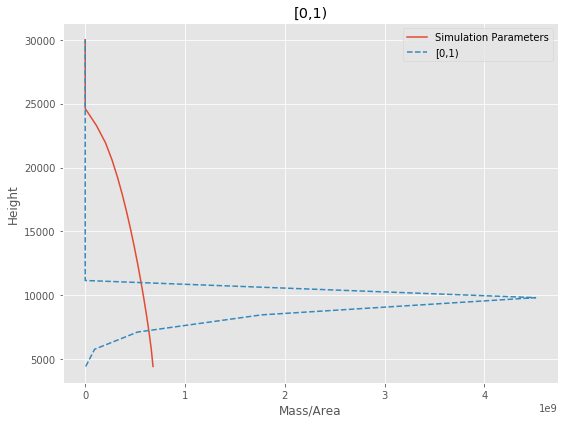

[0,1) Run Time: 0.11354 minutes


========[1,2)========
a* = 1.82079	b* = -5.83721	            h1* = 0.81077	u* = 0.62739	v* = 1.52169	            D* = 8.29804	ftt* = 8.77307	TM* = 22.25564
a = 7.17672	b = 1.00292	            h1 = 19234.00000	u = 1.87273	v = 4.57995	            D = 4016.00000	ftt = 6458.00000	TM = 4629137051.12431
Success: True, Optimization terminated successfully.
Iterations: 329
SSE: 0.7619980034657614


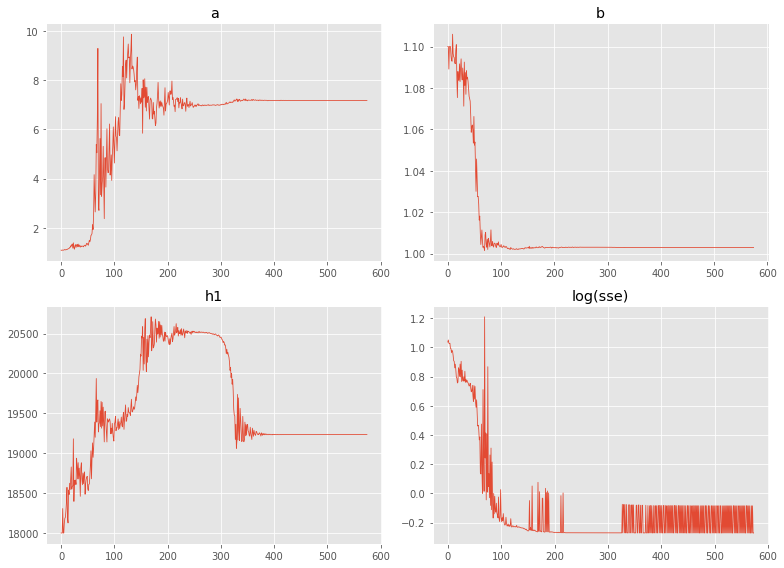

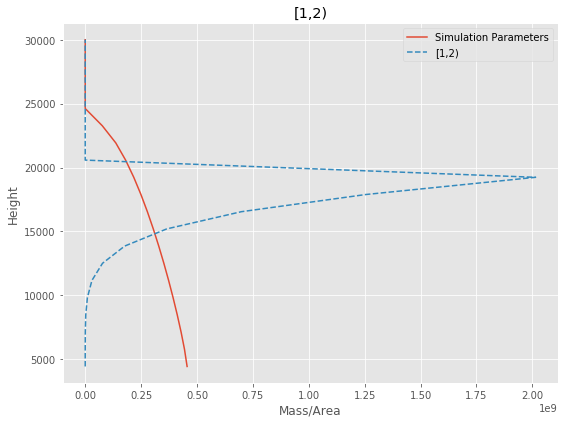

[1,2) Run Time: 0.11302 minutes


========[2,3)========
a* = 1.24336	b* = -2.55096	            h1* = 3.30804	u* = -32.62909	v* = -39.49242	            D* = 8.29804	ftt* = 8.77307	TM* = 21.68272
a = 4.46723	b = 1.07801	            h1 = 28922.20631	u = 0.00000	v = 0.00000	            D = 4016.00000	ftt = 6458.00000	TM = 2610270359.57395
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 637
SSE: 0.3128144208375061


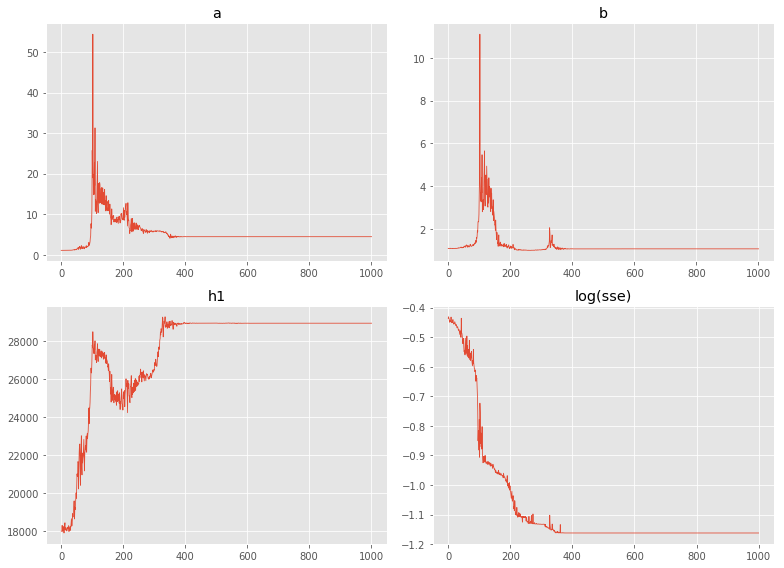

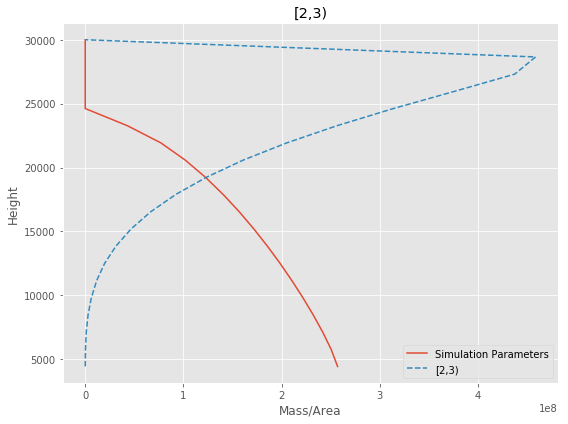

[2,3) Run Time: 0.18828 minutes


========[3,4)========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:700: RuntimeWarning: divide by zero encountered in double_scalars
  wind_speed = u/np.sin(wind_angle)
C:\Users\nmostert\Documents\repos\inversion_project\utils.py:705: RuntimeWarning: invalid value encountered in double_scalars
  v_wind_adj = np.sin(wind_angle)*windspeed_adj


a* = -2.71077	b* = -3.71595	            h1* = 0.38452	u* = -30.90374	v* = 0.53698	            D* = 8.29804	ftt* = 8.77307	TM* = 20.93619
a = 1.06649	b = 1.02433	            h1 = 15186.71823	u = 0.00000	v = 1.71084	            D = 4016.00000	ftt = 6458.00000	TM = 1237293118.15410
Success: True, Optimization terminated successfully.
Iterations: 189
SSE: 0.2898076311543179


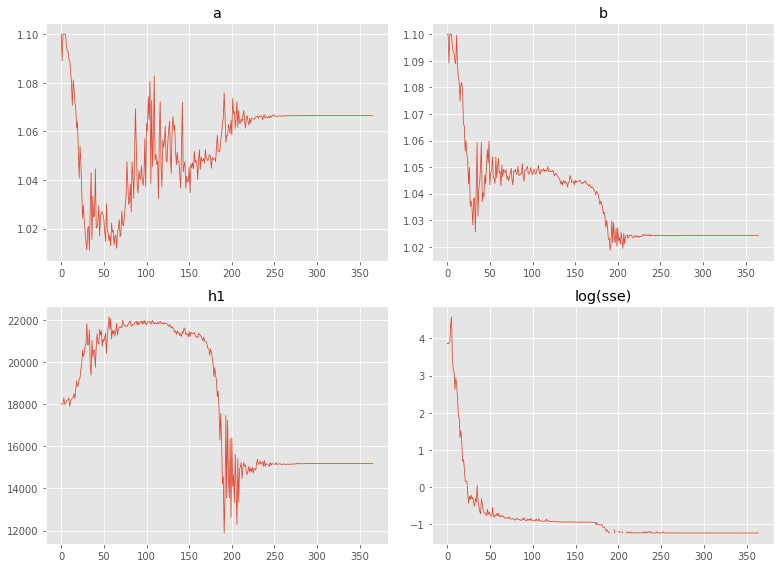

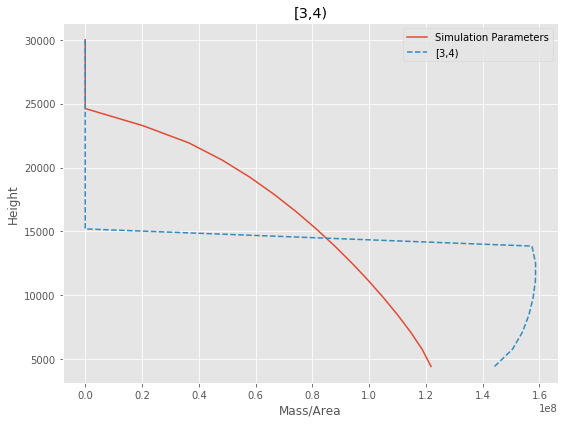

[3,4) Run Time: 0.07187 minutes


Total Run Time: 1.17760 minutes


In [11]:
df = obs_df


priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": 18000,
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True,
    "D": False,
    "ftt": False,
    "M": False
}


H = 30000

wind_angle = np.radians(55.5)


t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []


for phi_step in phi_steps:
    t = process_time()
    
    phi_df = df.copy()
    
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    
    priors_vals["M"] = mass_in_phi
    
    print("========%s========"%phi_step["interval"])
    
    out = gaussian_stack_inversion(
        phi_df, len(phi_df), 20, config["VENT_ELEVATION"], 
        H, 2500, [phi_step],
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
#     display(inversion_table)
    plume_trace = np.array(plume_trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    
    plt.tight_layout()
    plt.show()
     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                mass_in_phi)

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

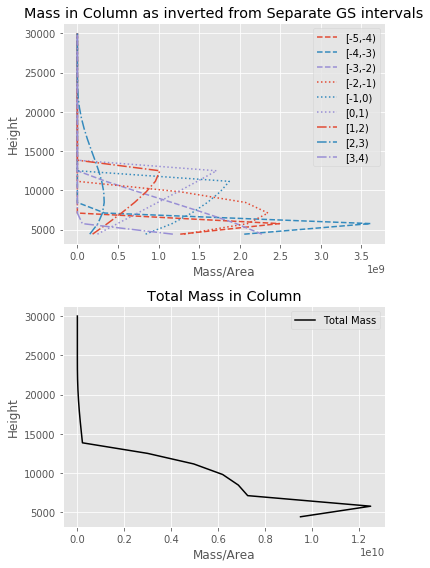

In [16]:
fig, axs = plt.subplots(2,1, figsize=(
    6, 8), facecolor='w', edgecolor='k')
ax1, ax2 = axs.ravel()
    
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

linestyles = ["C0--","C1--","C2--","C0:","C1:","C2:","C0-.","C1-.","C2-."]

# ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
totmass = np.zeros(len(inverted_masses_list[0]))
    
for i, (phi_step, mass) in enumerate(zip(phi_steps, inverted_masses_list)):
    totmass += mass
    ax1.plot(mass, 
         inversion_table["Height"], 
         linestyles[i], label=phi_step["interval"])
    
ax2.plot(totmass, inversion_table["Height"], "k-", label="Total Mass")
ax1.legend()
ax2.legend()

ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.set_title("Total Mass in Column")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

========[-5,-4)========
a* = 0.00089	b* = -3.68533	            h1* = -0.36796	u* = 2.12512	v* = 3.25483	            D* = 8.29804	ftt* = 8.77307	TM* = 22.04730
a = 2.00089	b = 1.02509	            h1 = 7073.94015	u = 8.37391	v = 25.91526	            D = 4016.00000	ftt = 6458.00000	TM = 3758564623.12040
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 615
SSE: 0.8647374119512795


,Height,Suspended Mass
0,"4,430.75",1.26729e+09
1,"5,776.5",2.49127e+09
2,"7,122.25",0
3,"8,468",0
4,"9,813.75",0
5,"11,159.5",0
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


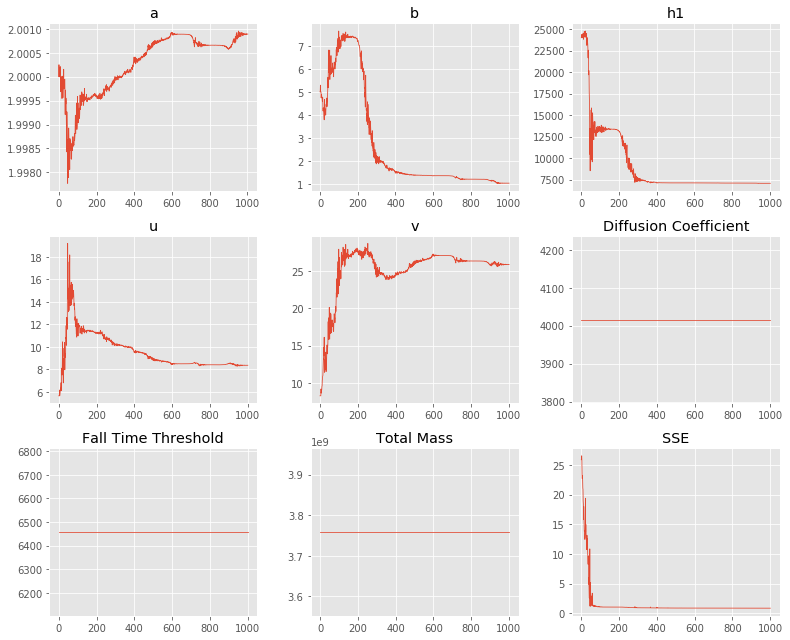

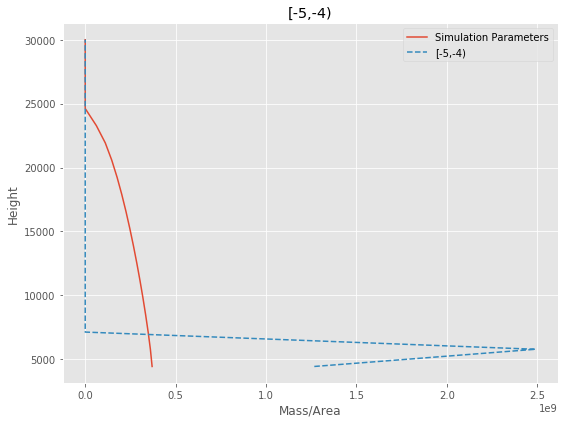

[-5,-4) Run Time: 0.18958 minutes


========[-4,-3)========
a* = 0.00538	b* = -1.65079	            h1* = -0.36323	u* = 1.80936	v* = 3.09866	            D* = 8.29804	ftt* = 8.77307	TM* = 22.51605
a = 2.00539	b = 1.19190	            h1 = 7122.25069	u = 6.10656	v = 22.16825	            D = 4016.00000	ftt = 6458.00000	TM = 6006169166.09182
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 614
SSE: 1.3571273073282597


,Height,Suspended Mass
0,"4,430.75",2.0559e+09
1,"5,776.5",3.61317e+09
2,"7,122.25",3.37095e+08
3,"8,468",0
4,"9,813.75",0
5,"11,159.5",0
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


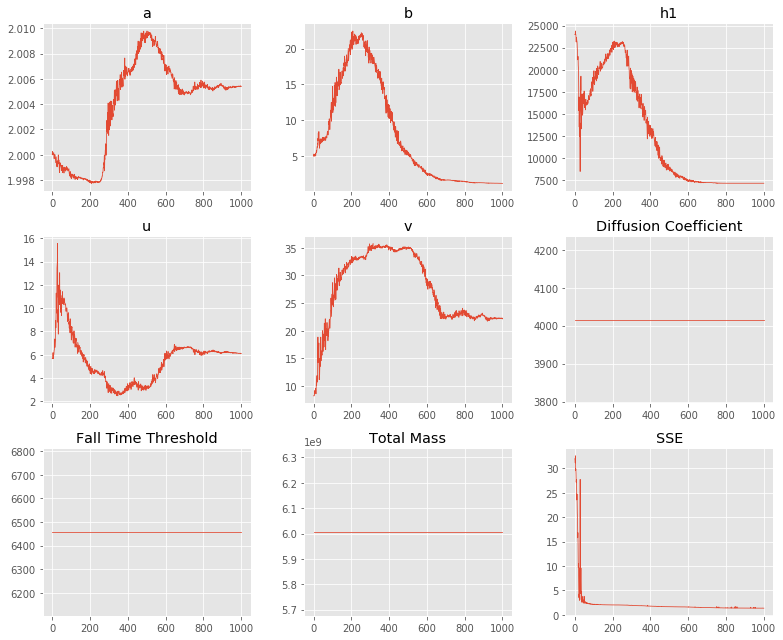

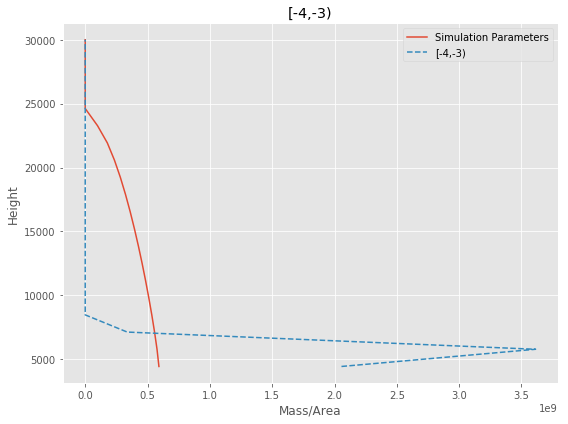

[-4,-3) Run Time: 0.19141 minutes


========[-3,-2)========
a* = -2.54394	b* = 0.11441	            h1* = 0.13348	u* = 1.96530	v* = 2.85274	            D* = 8.29804	ftt* = 8.77307	TM* = 22.81119
a = 1.07856	b = 2.12121	            h1 = 12505.28675	u = 7.13704	v = 17.33518	            D = 4016.00000	ftt = 6458.00000	TM = 8068164622.31213
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 621
SSE: 2.6436084467854615


,Height,Suspended Mass
0,"4,430.75",2.27224e+09
1,"5,776.5",1.9558e+09
2,"7,122.25",1.57218e+09
3,"8,468",1.16476e+09
4,"9,813.75",7.52342e+08
5,"11,159.5",3.50853e+08
6,"12,505.2","2,713.35"
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


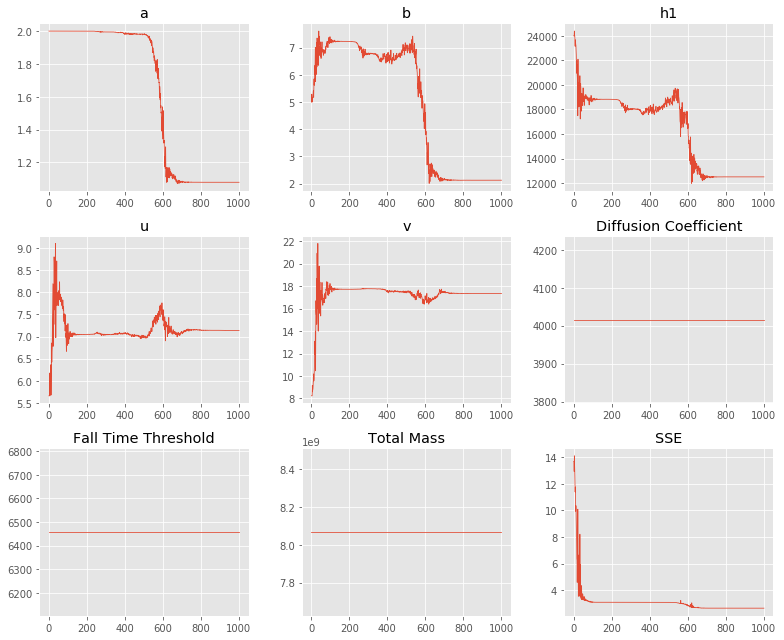

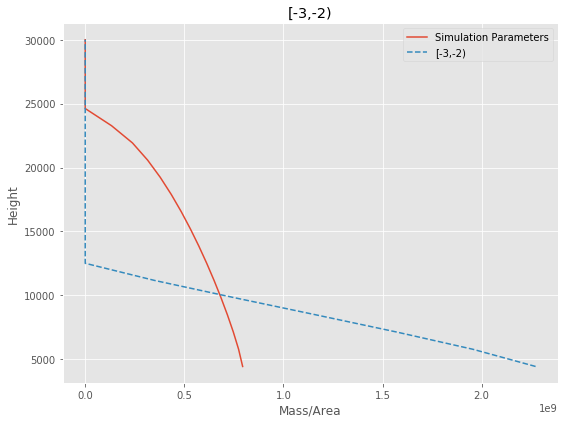

[-3,-2) Run Time: 0.19531 minutes


========[-2,-1)========
a* = 0.00311	b* = 0.02089	            h1* = 0.01116	u* = 2.05796	v* = 2.76311	            D* = 8.29804	ftt* = 8.77307	TM* = 22.93272
a = 2.00312	b = 2.02111	            h1 = 11159.50021	u = 7.83000	v = 15.84906	            D = 4016.00000	ftt = 6458.00000	TM = 9110738766.61036
Success: True, Optimization terminated successfully.
Iterations: 295
SSE: 5.192222251867695


,Height,Suspended Mass
0,"4,430.75",1.31462e+09
1,"5,776.5",2.09803e+09
2,"7,122.25",2.34896e+09
3,"8,468",2.07203e+09
4,"9,813.75",1.27709e+09
5,"11,159.5",170.996
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


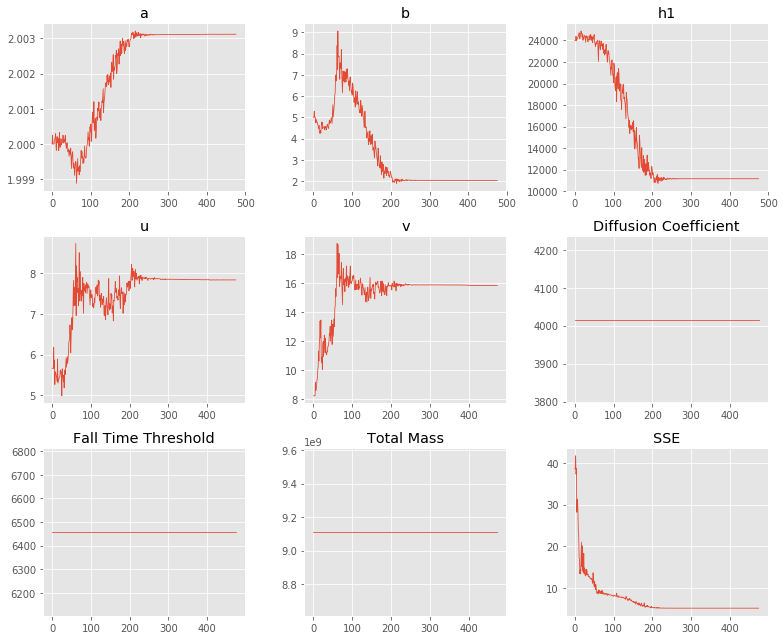

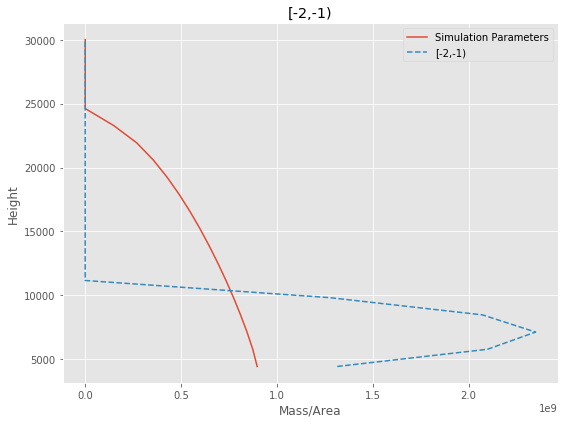

[-2,-1) Run Time: 0.09740 minutes


========[-1,0)========
a* = -0.72802	b* = -3.35680	            h1* = 0.12397	u* = 1.94357	v* = 2.56160	            D* = 8.29804	ftt* = 8.77307	TM* = 22.88064
a = 1.48287	b = 1.03485	            h1 = 12401.12929	u = 6.98365	v = 12.95655	            D = 4016.00000	ftt = 6458.00000	TM = 8648366582.16271
Success: True, Optimization terminated successfully.
Iterations: 565
SSE: 1.9639364117514417


,Height,Suspended Mass
0,"4,430.75",8.40654e+08
1,"5,776.5",1.16728e+09
2,"7,122.25",1.40854e+09
3,"8,468",1.60193e+09
4,"9,813.75",1.75833e+09
5,"11,159.5",1.87164e+09
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


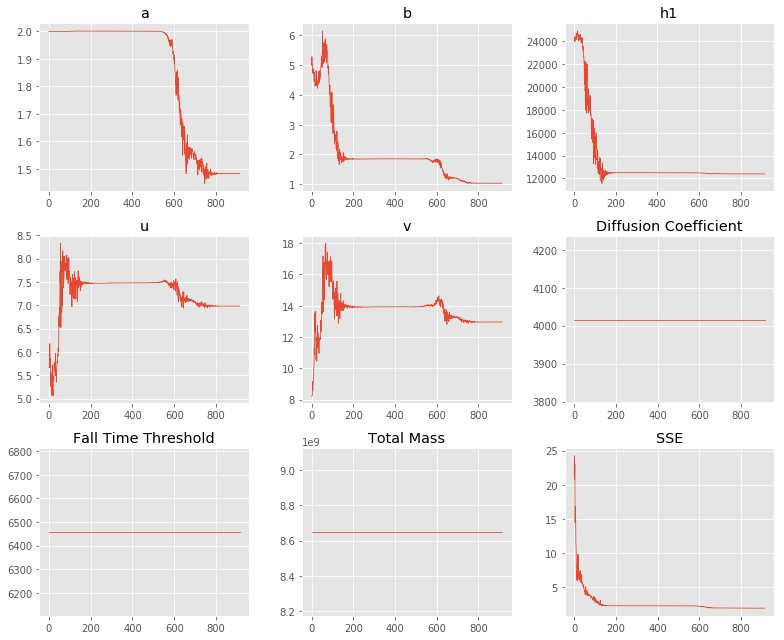

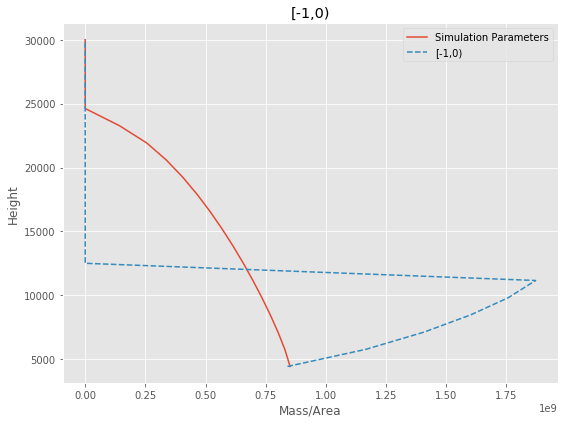

[-1,0) Run Time: 0.17865 minutes


========[0,1)========
a* = 0.00443	b* = -4.73319	            h1* = 0.25768	u* = 1.84403	v* = 2.26194	            D* = 8.29804	ftt* = 8.77307	TM* = 22.65494
a = 2.00444	b = 1.00880	            h1 = 13850.99680	u = 6.32199	v = 9.60171	            D = 4016.00000	ftt = 6458.00000	TM = 6901066909.64173
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 623
SSE: 0.20113907344375329


,Height,Suspended Mass
0,"4,430.75",2.47038e+08
1,"5,776.5",4.94928e+08
2,"7,122.25",7.42539e+08
3,"8,468",9.89374e+08
4,"9,813.75",1.23482e+09
5,"11,159.5",1.4777e+09
6,"12,505.2",1.71467e+09
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


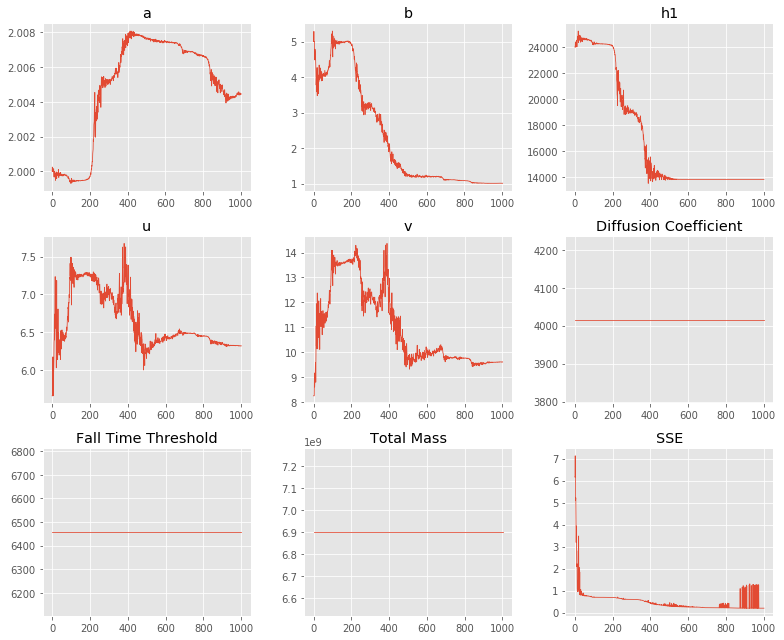

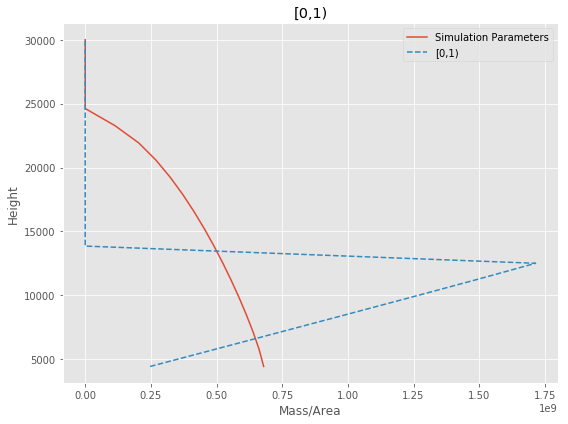

[0,1) Run Time: 0.19141 minutes


========[1,2)========
a* = 0.01472	b* = -1.92875	            h1* = 0.25724	u* = 1.84947	v* = 2.23534	            D* = 8.29804	ftt* = 8.77307	TM* = 22.25564
a = 2.01483	b = 1.14533	            h1 = 13846.30486	u = 6.35644	v = 9.34962	            D = 4016.00000	ftt = 6458.00000	TM = 4629137051.12431
Success: True, Optimization terminated successfully.
Iterations: 590
SSE: 0.03324297606923445


,Height,Suspended Mass
0,"4,430.75",1.87161e+08
1,"5,776.5",3.69807e+08
2,"7,122.25",5.43455e+08
3,"8,468",7.04467e+08
4,"9,813.75",8.4729e+08
5,"11,159.5",9.61081e+08
6,"12,505.2",1.01588e+09
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


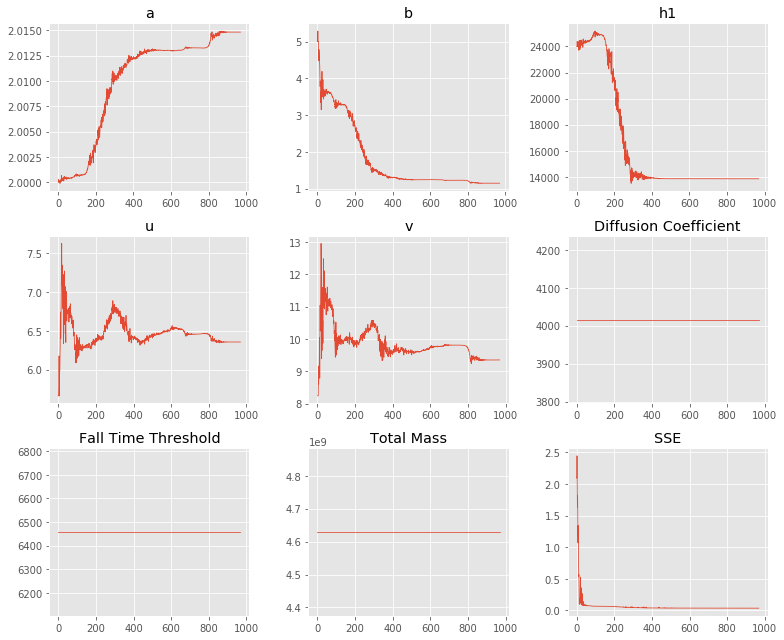

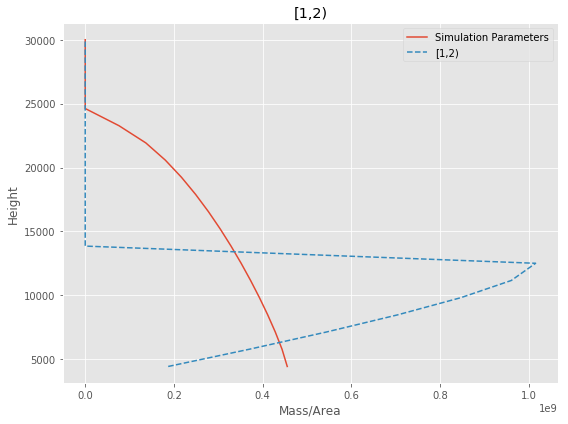

[1,2) Run Time: 0.18542 minutes


========[2,3)========
a* = 0.00009	b* = 1.02517	            h1* = 1.66049	u* = 1.99506	v* = 2.16934	            D* = 8.29804	ftt* = 8.77307	TM* = 21.68272
a = 2.00009	b = 3.78756	            h1 = 24807.63184	u = 7.35267	v = 8.75248	            D = 4016.00000	ftt = 6458.00000	TM = 2610270359.57395
Success: True, Optimization terminated successfully.
Iterations: 104
SSE: 0.0001480649913254393


,Height,Suspended Mass
0,"4,430.75",1.52862e+08
1,"5,776.5",2.52721e+08
2,"7,122.25",3.09005e+08
3,"8,468",3.30446e+08
4,"9,813.75",3.25062e+08
5,"11,159.5",3.00129e+08
6,"12,505.2",2.62172e+08
7,"13,851",2.16938e+08
8,"15,196.8",1.69373e+08
9,"16,542.5",1.2359e+08


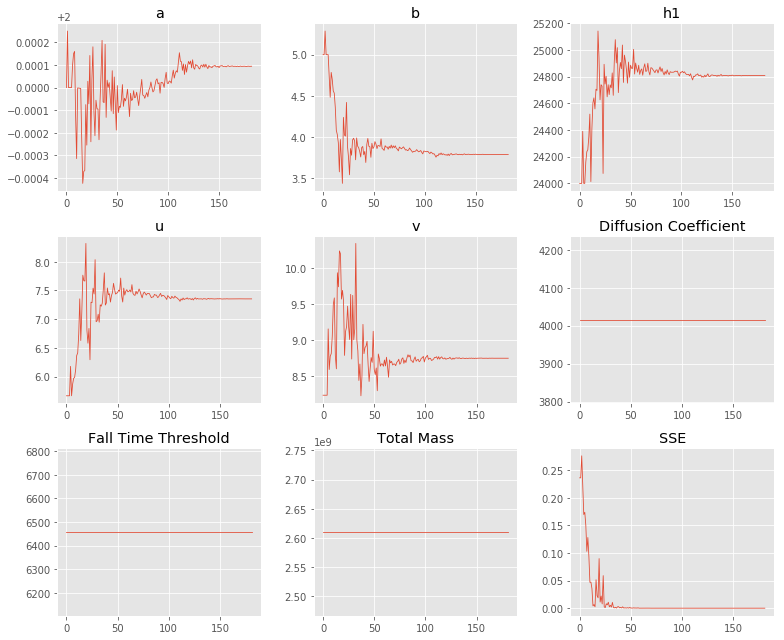

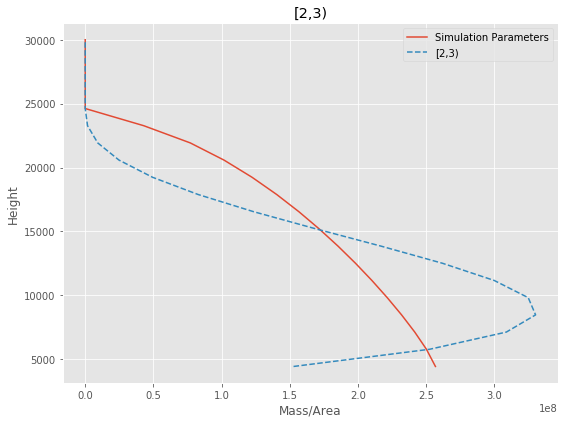

[2,3) Run Time: 0.04557 minutes


========[3,4)========
a* = 0.00759	b* = 1.43970	            h1* = -0.39981	u* = 1.74137	v* = 2.48169	            D* = 8.29804	ftt* = 8.77307	TM* = 20.93619
a = 2.00762	b = 5.21944	            h1 = 6750.71972	u = 5.70513	v = 11.96150	            D = 4016.00000	ftt = 6458.00000	TM = 1237293118.15410
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 632
SSE: 2.0458563940452245e-06


,Height,Suspended Mass
0,"4,430.75",1.17649e+09
1,"5,776.5",6.08026e+07
2,"7,122.25",0
3,"8,468",0
4,"9,813.75",0
5,"11,159.5",0
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


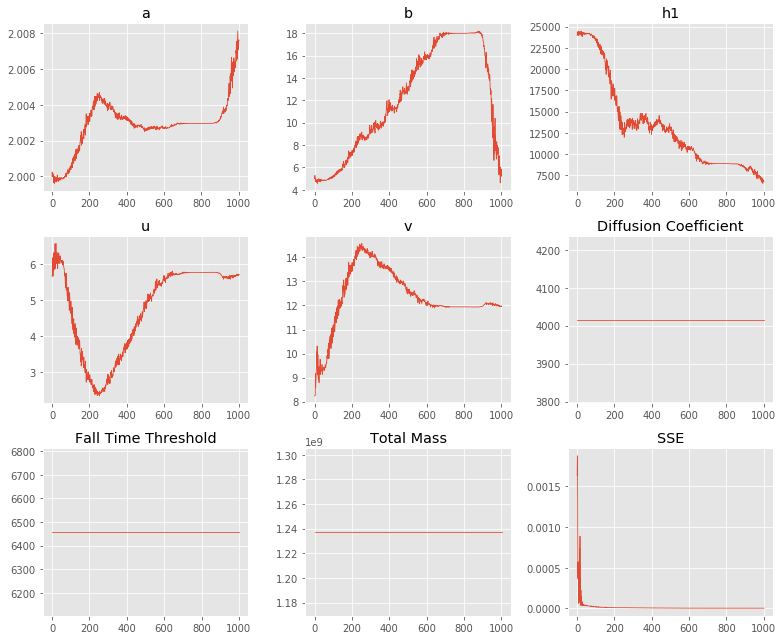

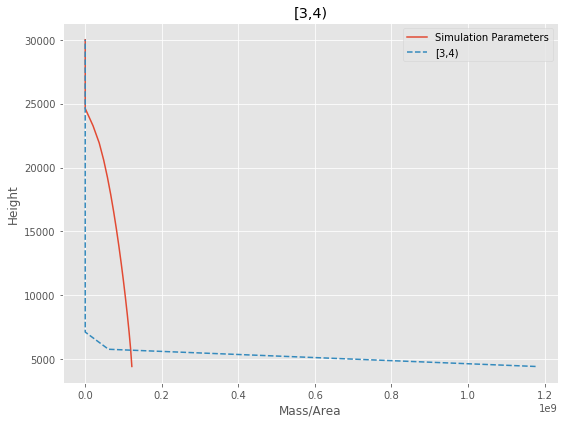

[3,4) Run Time: 0.19896 minutes


Total Run Time: 1.47370 minutes


In [14]:
df = forward_df



priors_vals = {
    "a": 2,
    "b": 5,
    "h1": config["PLUME_HEIGHT"],
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True,
    "D": False,
    "ftt": False,
    "M": False
}


H = 30000

wind_angle = np.radians(55.5)


t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []


for phi_step in phi_steps:
    t = process_time()
    
    phi_df = df.copy()
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    
    priors_vals["M"] = mass_in_phi
    
    print("========%s========"%phi_step["interval"])
    
    out = gaussian_stack_inversion(
        phi_df, len(phi_df), 20, config["VENT_ELEVATION"], 
        H, 2500, [phi_step],
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                mass_in_phi)

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

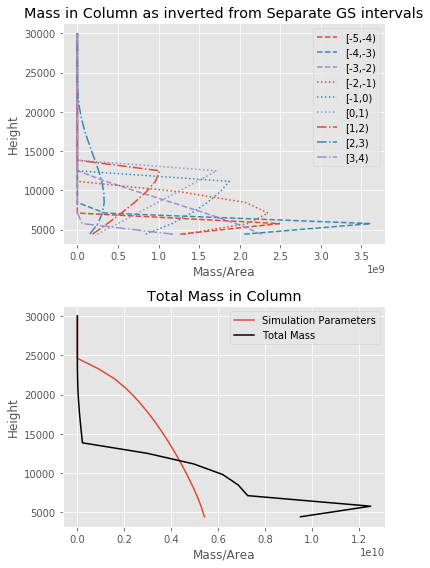

,Dataset,a,b,h1,u,v,D,ftt,M
0,"[-5,-4)",2.00089,1.02509,"7,073.94",8.37391,25.9153,"4,016","6,458",3.75856e+09
1,"[-4,-3)",2.00539,1.1919,"7,122.25",6.10656,22.1683,"4,016","6,458",6.00617e+09
2,"[-3,-2)",1.07856,2.12121,"12,505.3",7.13704,17.3352,"4,016","6,458",8.06816e+09
3,"[-2,-1)",2.00312,2.02111,"11,159.5",7.83,15.8491,"4,016","6,458",9.11074e+09
4,"[-1,0)",1.48287,1.03485,"12,401.1",6.98365,12.9565,"4,016","6,458",8.64837e+09
5,"[0,1)",2.00444,1.0088,"13,851",6.32199,9.60171,"4,016","6,458",6.90107e+09
6,"[1,2)",2.01483,1.14533,"13,846.3",6.35644,9.34962,"4,016","6,458",4.62914e+09
7,"[2,3)",2.00009,3.78756,"24,807.6",7.35267,8.75248,"4,016","6,458",2.61027e+09
8,"[3,4)",2.00762,5.21944,"6,750.72",5.70513,11.9615,"4,016","6,458",1.23729e+09


In [16]:
fig, axs = plt.subplots(2,1, figsize=(
    6, 8), facecolor='w', edgecolor='k')
ax1, ax2 = axs.ravel()
    
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

linestyles = ["C0--","C1--","C2--","C0:","C1:","C2:","C0-.","C1-.","C2-."]


totmass = np.zeros(len(inverted_masses_list[0]))
    
for i, (phi_step, mass) in enumerate(zip(phi_steps, inverted_masses_list)):
    totmass += mass
    ax1.plot(mass, 
         inversion_table["Height"], 
         linestyles[i], label=phi_step["interval"])
ax2.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
ax2.plot(totmass, inversion_table["Height"], "k-", label="Total Mass")
ax1.legend()
ax2.legend()

ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.set_title("Total Mass in Column")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

params_df = pd.DataFrame(params_list)
params_df["Dataset"] = [phi_step["interval"] for phi_step in phi_steps]
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

Now, why is the column shape not preserved? We are assuming a well mixed plume, but that does not appear to be the case here, since each phi class inverts with a different phi. 


========[-5,-4)========


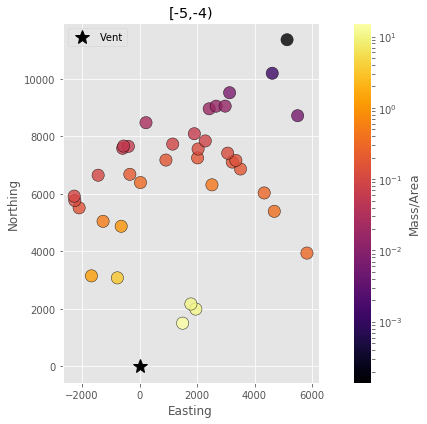

a* = -6.02850	b* = -0.68529	            h1* = 1.49994	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 9.17854	TM* = 22.04730
a = 1.00241	b = 1.50395	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 9687.00000	TM = 3758564623.12040
Success: True, Optimization terminated successfully.
Iterations: 93
SSE: 0.0006396873058370123


,Height,Suspended Mass
0,"4,430.75",3.67615e+08
1,"5,776.5",3.55243e+08
2,"7,122.25",3.42105e+08
3,"8,468",3.28303e+08
4,"9,813.75",3.13814e+08
5,"11,159.5",2.98572e+08
6,"12,505.2",2.82475e+08
7,"13,851",2.6538e+08
8,"15,196.8",2.47091e+08
9,"16,542.5",2.27331e+08


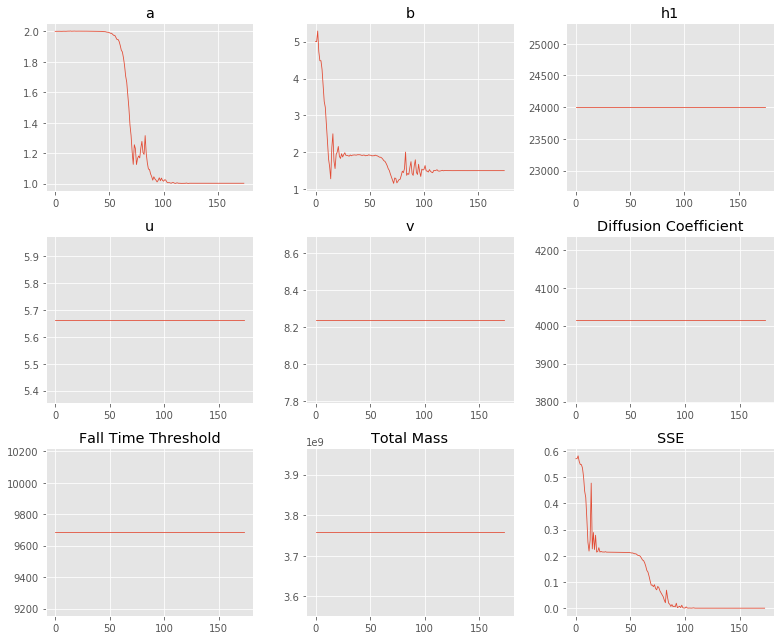

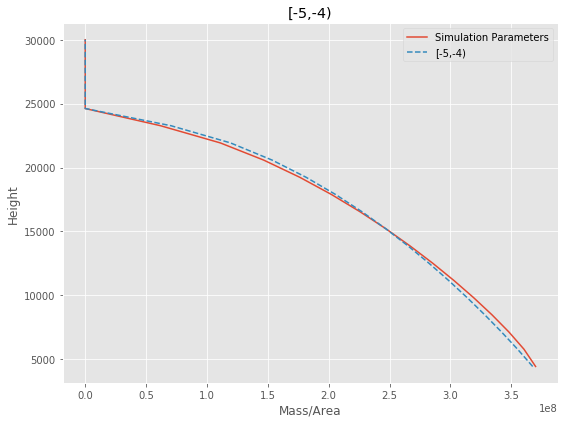

[-5,-4) Run Time: 0.07422 minutes


========[-4,-3)========


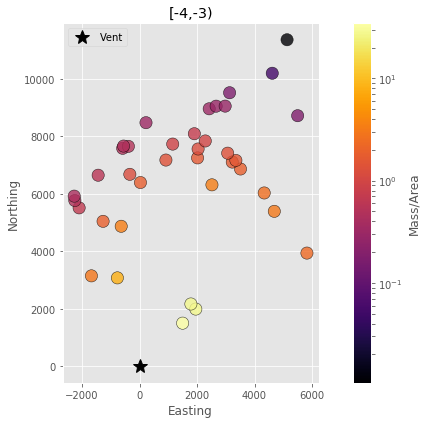

a* = -5.37955	b* = -0.69513	            h1* = 1.49994	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 9.17854	TM* = 22.51605
a = 1.00461	b = 1.49901	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 9687.00000	TM = 6006169166.09182
Success: True, Optimization terminated successfully.
Iterations: 91
SSE: 0.002066726751850682


,Height,Suspended Mass
0,"4,430.75",5.83507e+08
1,"5,776.5",5.64928e+08
2,"7,122.25",5.44728e+08
3,"8,468",5.23296e+08
4,"9,813.75",5.00672e+08
5,"11,159.5",4.7678e+08
6,"12,505.2",4.51475e+08
7,"13,851",4.24538e+08
8,"15,196.8",3.95661e+08
9,"16,542.5",3.64402e+08


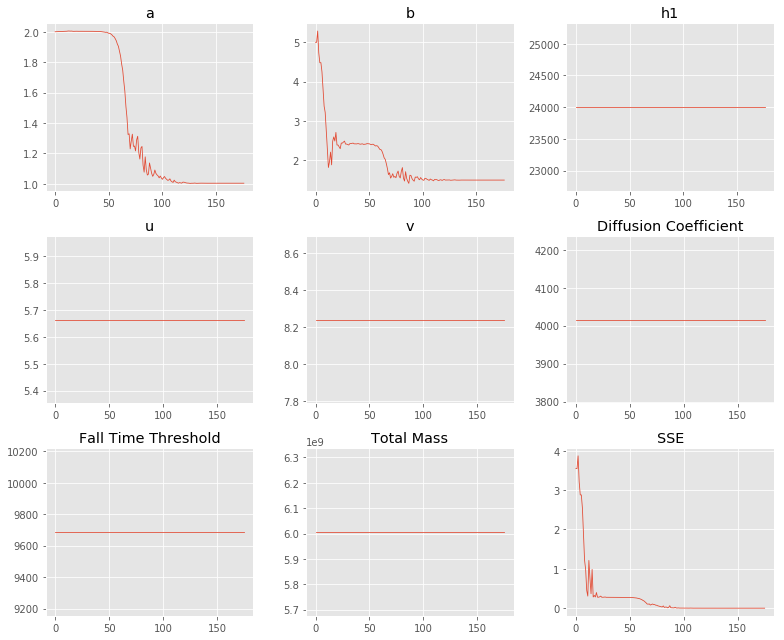

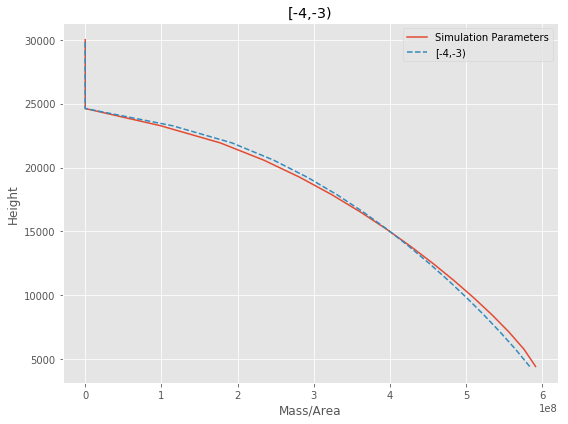

[-4,-3) Run Time: 0.07370 minutes


========[-3,-2)========


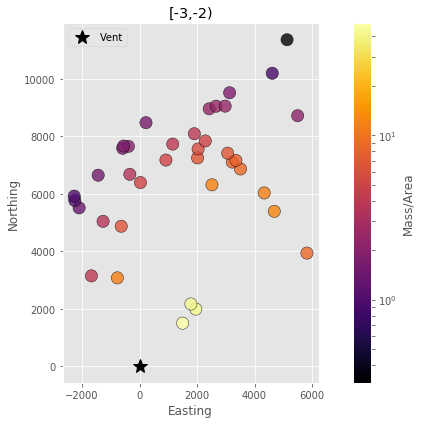

a* = -5.03322	b* = -0.66942	            h1* = 1.49994	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 9.17854	TM* = 22.81119
a = 1.00652	b = 1.51200	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 9687.00000	TM = 8068164622.31213
Success: True, Optimization terminated successfully.
Iterations: 106
SSE: 0.005418924496416616


,Height,Suspended Mass
0,"4,430.75",7.87866e+08
1,"5,776.5",7.63083e+08
2,"7,122.25",7.35633e+08
3,"8,468",7.06316e+08
4,"9,813.75",6.75271e+08
5,"11,159.5",6.42439e+08
6,"12,505.2",6.07645e+08
7,"13,851",5.70611e+08
8,"15,196.8",5.30936e+08
9,"16,542.5",4.88035e+08


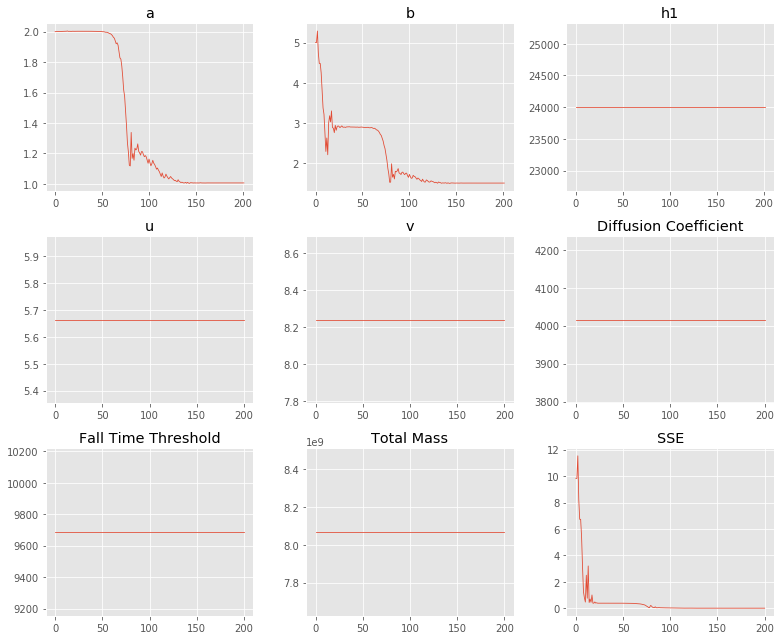

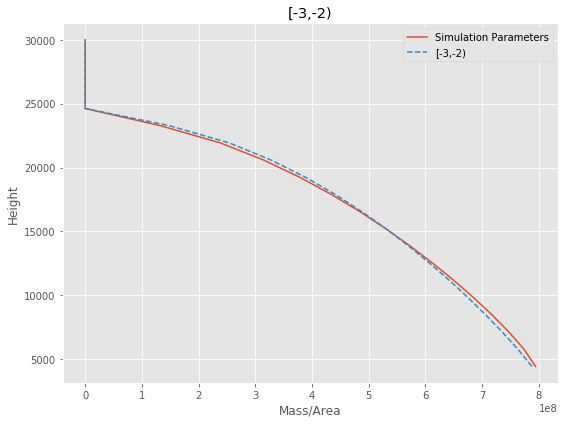

[-3,-2) Run Time: 0.07865 minutes


========[-2,-1)========


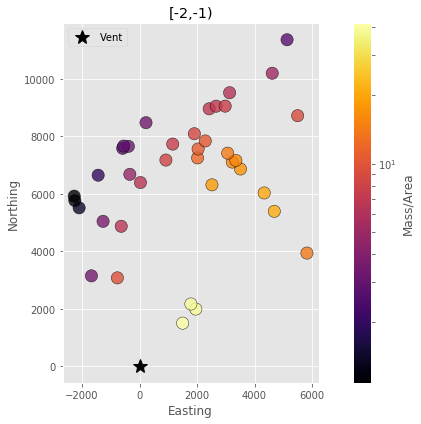

a* = -5.33146	b* = -0.64339	            h1* = 1.49994	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 9.17854	TM* = 22.93272
a = 1.00484	b = 1.52551	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 9687.00000	TM = 9110738766.61036
Success: True, Optimization terminated successfully.
Iterations: 92
SSE: 0.011487073877960276


,Height,Suspended Mass
0,"4,430.75",8.99722e+08
1,"5,776.5",8.69569e+08
2,"7,122.25",8.36849e+08
3,"8,468",8.02209e+08
4,"9,813.75",7.65724e+08
5,"11,159.5",7.27291e+08
6,"12,505.2",6.86695e+08
7,"13,851",6.43616e+08
8,"15,196.8",5.97597e+08
9,"16,542.5",5.47983e+08


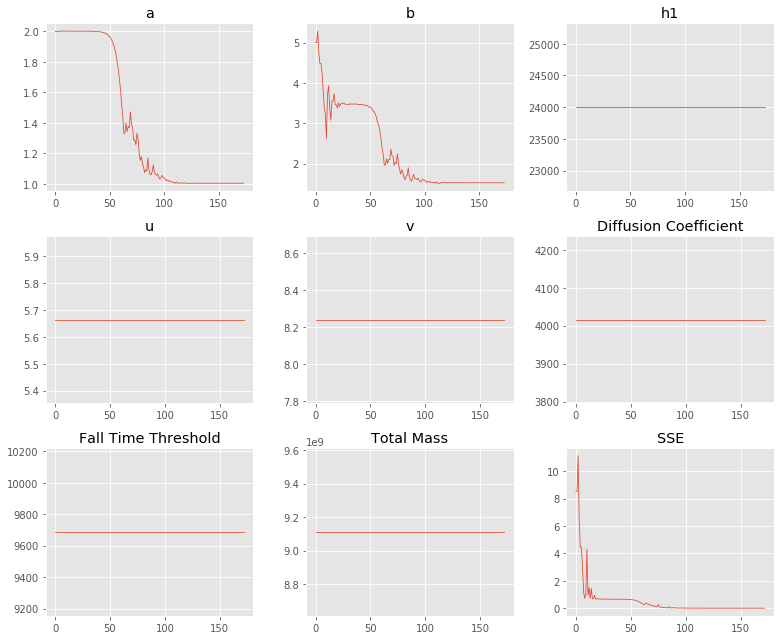

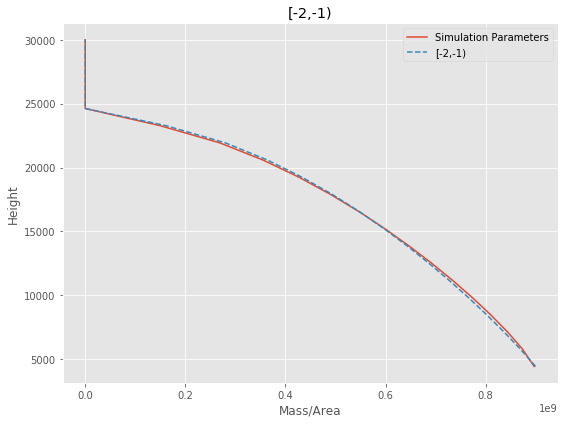

[-2,-1) Run Time: 0.06771 minutes


========[-1,0)========


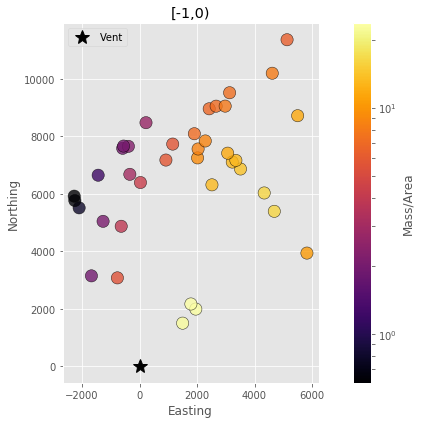

a* = -5.54630	b* = -0.57702	            h1* = 1.49994	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 9.17854	TM* = 22.88064
a = 1.00390	b = 1.56157	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 9687.00000	TM = 8648366582.16271
Success: True, Optimization terminated successfully.
Iterations: 89
SSE: 0.017586892492785153


,Height,Suspended Mass
0,"4,430.75",8.7463e+08
1,"5,776.5",8.42603e+08
2,"7,122.25",8.08351e+08
3,"8,468",7.72364e+08
4,"9,813.75",7.34677e+08
5,"11,159.5",6.9518e+08
6,"12,505.2",6.53668e+08
7,"13,851",6.09839e+08
8,"15,196.8",5.63276e+08
9,"16,542.5",5.13379e+08


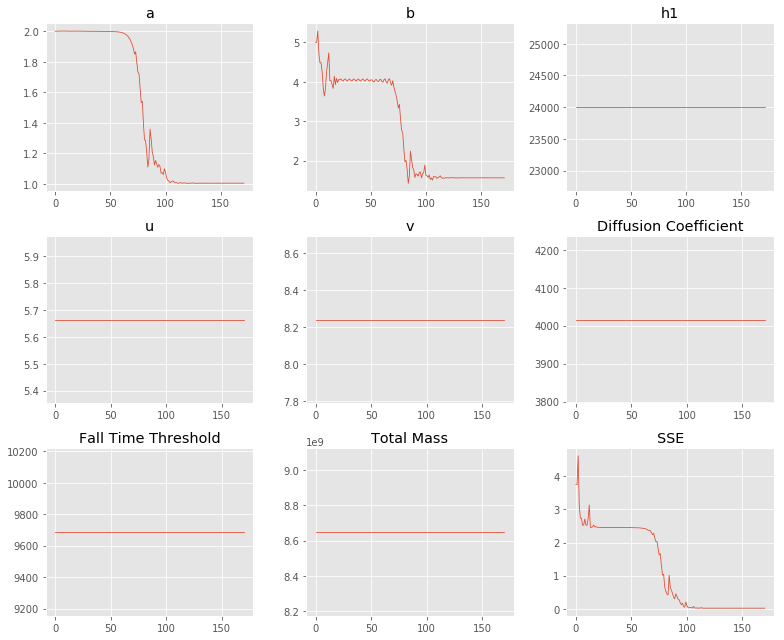

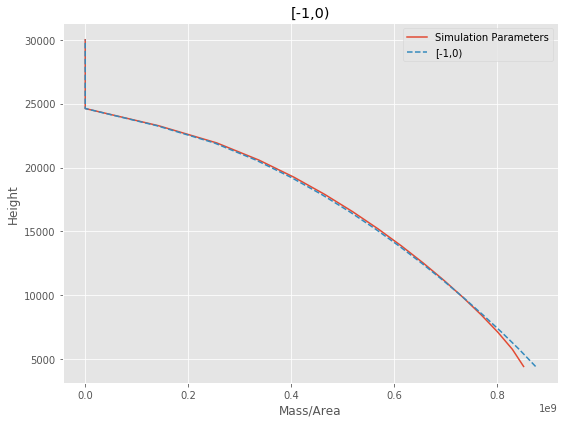

[-1,0) Run Time: 0.06745 minutes


========[0,1)========


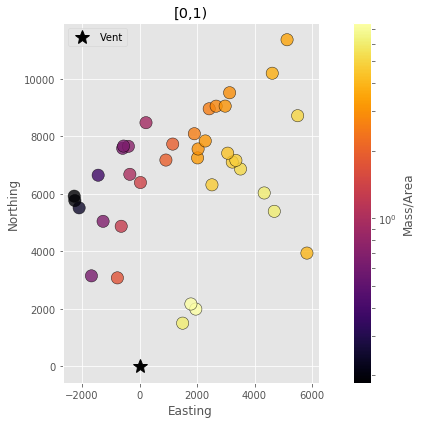

a* = -5.32985	b* = -0.49151	            h1* = 1.49994	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 9.17854	TM* = 22.65494
a = 1.00484	b = 1.61170	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 9687.00000	TM = 6901066909.64173
Success: True, Optimization terminated successfully.
Iterations: 80
SSE: 0.06019428988149323


,Height,Suspended Mass
0,"4,430.75",7.18169e+08
1,"5,776.5",6.89855e+08
2,"7,122.25",6.59524e+08
3,"8,468",6.27713e+08
4,"9,813.75",5.94503e+08
5,"11,159.5",5.59835e+08
6,"12,505.2",5.23567e+08
7,"13,851",4.85483e+08
8,"15,196.8",4.45278e+08
9,"16,542.5",4.02513e+08


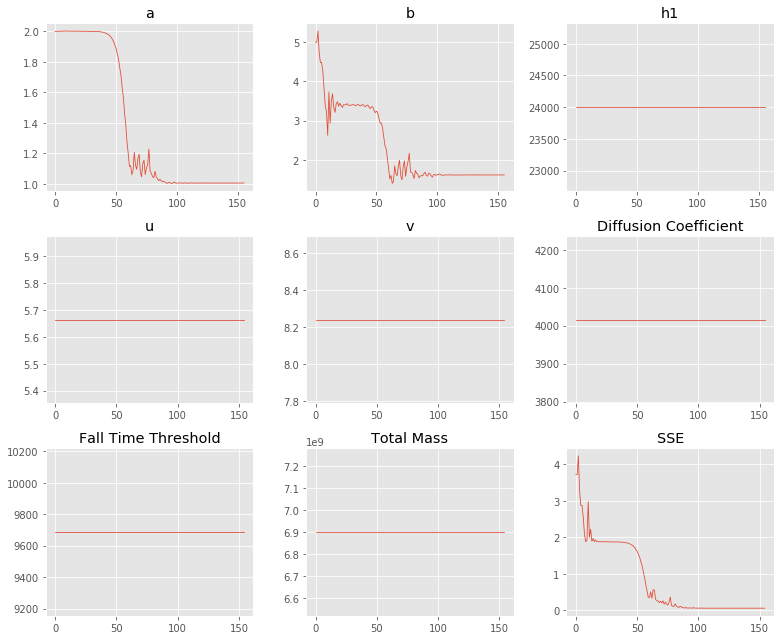

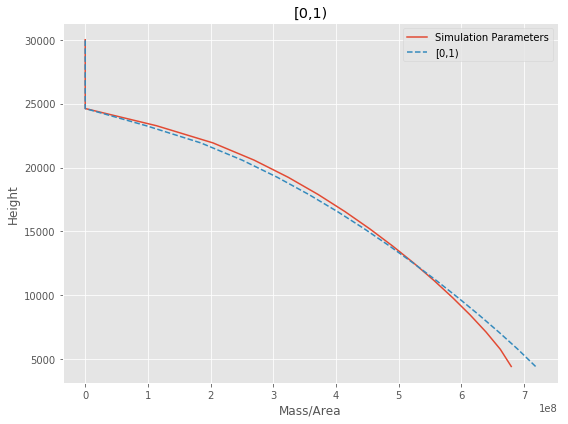

[0,1) Run Time: 0.06406 minutes


========[1,2)========


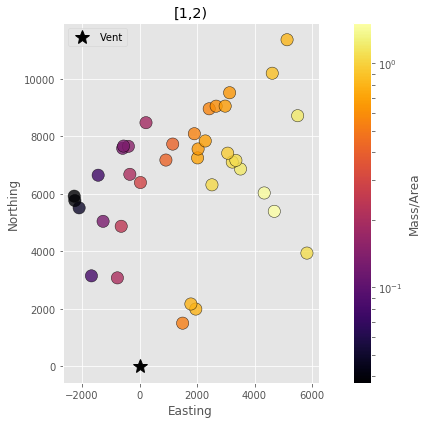

a* = -3.88627	b* = -0.61669	            h1* = 1.49994	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 9.17854	TM* = 22.25564
a = 1.02052	b = 1.53973	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 9687.00000	TM = 4629137051.12431
Success: True, Optimization terminated successfully.
Iterations: 80
SSE: 0.03831875677412034


,Height,Suspended Mass
0,"4,430.75",4.49622e+08
1,"5,776.5",4.38858e+08
2,"7,122.25",4.24576e+08
3,"8,468",4.08359e+08
4,"9,813.75",3.9065e+08
5,"11,159.5",3.71578e+08
6,"12,505.2",3.51133e+08
7,"13,851",3.29212e+08
8,"15,196.8",3.05619e+08
9,"16,542.5",2.80048e+08


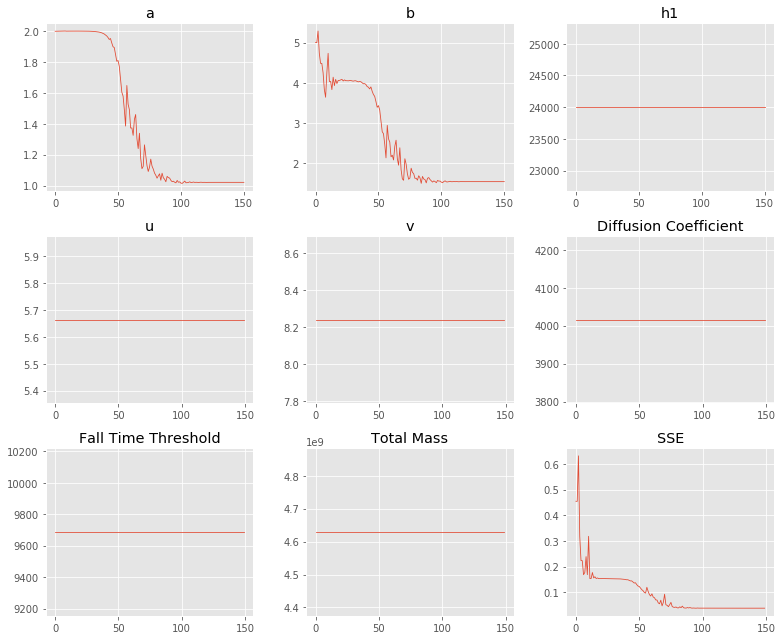

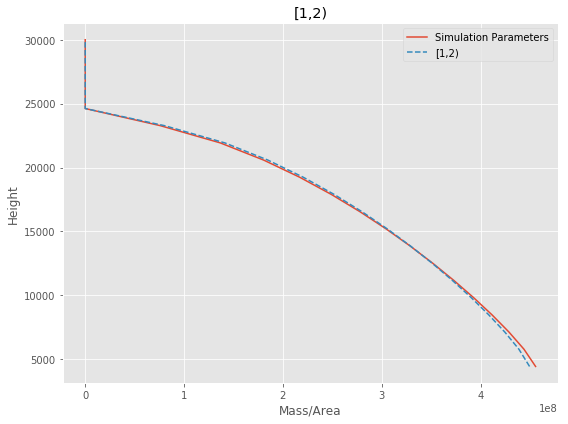

[1,2) Run Time: 0.06094 minutes


========[2,3)========


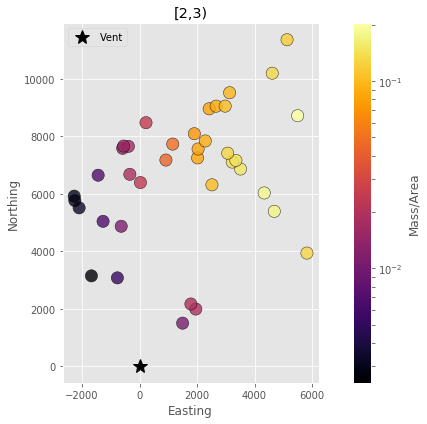

a* = -3.60836	b* = -0.15519	            h1* = 1.49994	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 9.17854	TM* = 21.68272
a = 1.02710	b = 1.85626	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 9687.00000	TM = 2610270359.57395
Success: True, Optimization terminated successfully.
Iterations: 101
SSE: 0.018756802005905245


,Height,Suspended Mass
0,"4,430.75",3.0033e+08
1,"5,776.5",2.87913e+08
2,"7,122.25",2.72586e+08
3,"8,468",2.55853e+08
4,"9,813.75",2.38185e+08
5,"11,159.5",2.19784e+08
6,"12,505.2",2.00742e+08
7,"13,851",1.81095e+08
8,"15,196.8",1.6084e+08
9,"16,542.5",1.39939e+08


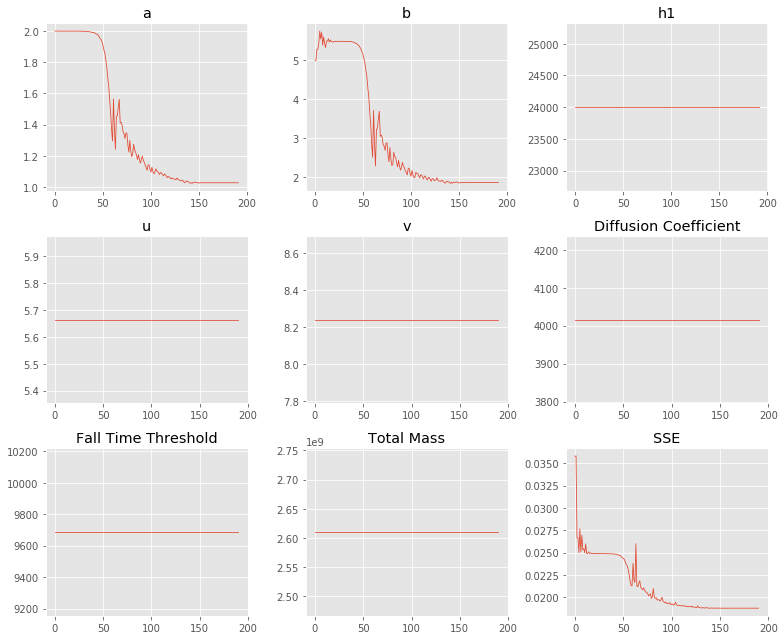

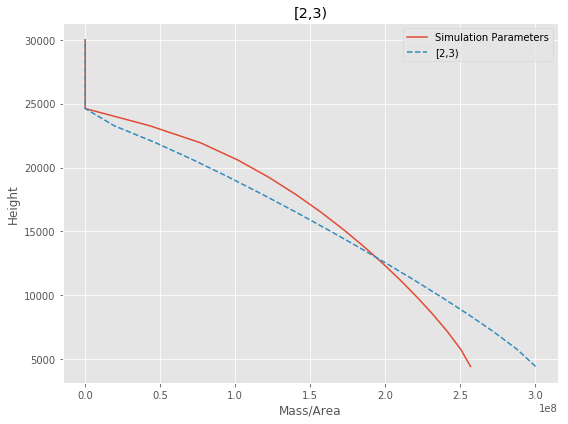

[2,3) Run Time: 0.06927 minutes


========[3,4)========


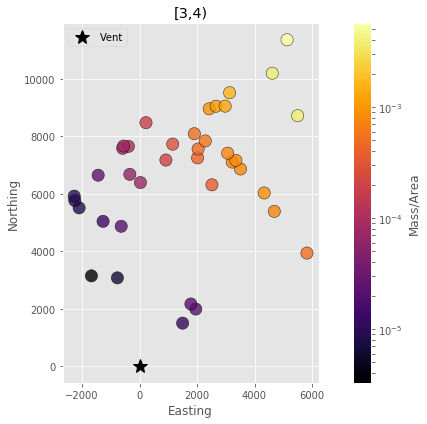

a* = -3.50557	b* = 1.49755	            h1* = 1.49994	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 9.17854	TM* = 20.93619
a = 1.03003	b = 5.47070	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 9687.00000	TM = 1237293118.15410
Success: True, Optimization terminated successfully.
Iterations: 119
SSE: 0.0002594085319760041


,Height,Suspended Mass
0,"4,430.75",3.79069e+08
1,"5,776.5",2.81465e+08
2,"7,122.25",2.0219e+08
3,"8,468",1.40662e+08
4,"9,813.75",9.44325e+07
5,"11,159.5",6.0811e+07
6,"12,505.2",3.72418e+07
7,"13,851",2.14295e+07
8,"15,196.8",1.13854e+07
9,"16,542.5",5.44012e+06


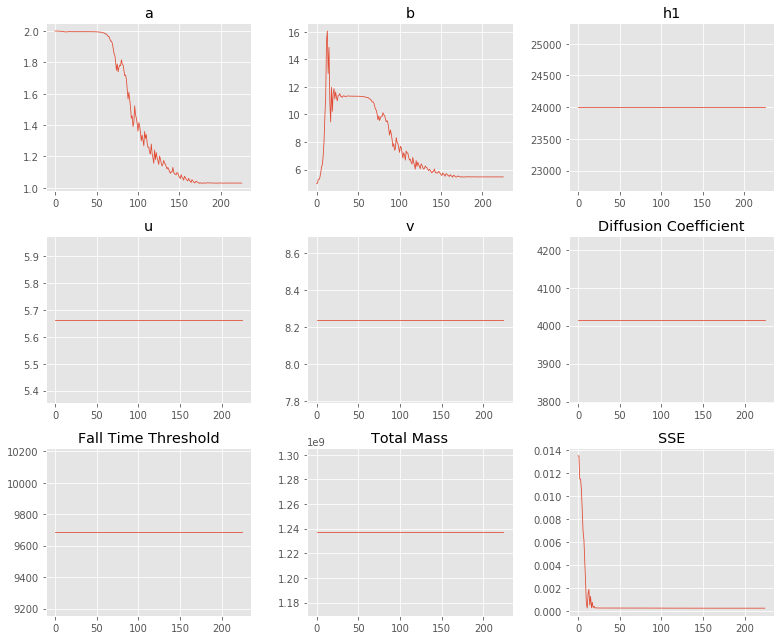

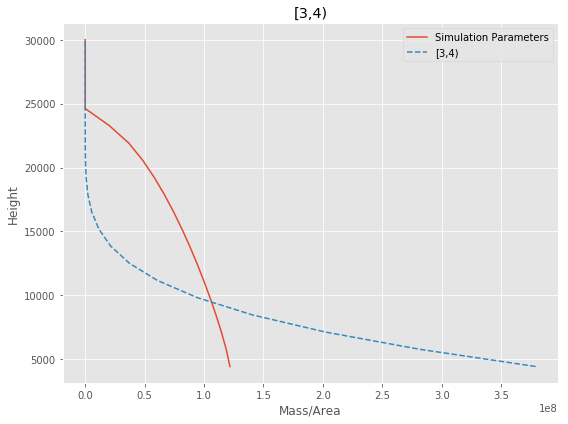

[3,4) Run Time: 0.08125 minutes


Total Run Time: 0.63724 minutes


In [19]:
df = forward_df


# priors_vals = {
#     "a": 2,
#     "b": 5,
#     "h1": 18000,
#     "u": 5,
#     "v": 6,
#     "D": 4000,
#     "ftt": 6000,
#     "M": config["ERUPTION_MASS"]
# }

# invert_params = {
#     "a" : True,
#     "b" : True,
#     "h1" : True,
#     "u": True,
#     "v": True,
#     "D": True,
#     "ftt": True,
#     "M": False
# }

priors_vals = {
    "a": 2,
    "b": 5,
    "h1": config["PLUME_HEIGHT"],
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"]*1.5,
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : False,
    "u": False,
    "v": False,
    "D": False,
    "ftt": False,
    "M": False
}


H = 30000

wind_angle = np.radians(55.5)


t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []


for phi_step in phi_steps:
    t = process_time()
    
    phi_df = df.copy()
    
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    
    priors_vals["M"] = mass_in_phi
    
    print("========%s========"%phi_step["interval"])
    
    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 2500, [phi_step], (config["ALPHA"],config["BETA"]), mass_in_phi, 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    
    fig, ax = plt.subplots(1, 1, figsize=(10,6))

    vis.plot_sample(post_df, vent=(0,0), log=True, bounds=None,
                title=phi_step["interval"], cbar_label="Mass/Area", ax = ax)
    plt.tight_layout()
    plt.show()

    out = gaussian_stack_inversion(
        post_df, len(post_df), 20, config["VENT_ELEVATION"], 
        H, 2500, [phi_step],
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                mass_in_phi)

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

   

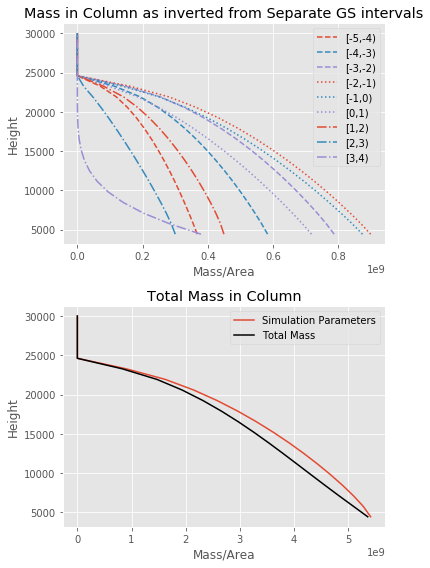

,Grain Size,a,b,h1,u,v,D,ftt,M
0,"[-5,-4)",1.00241,1.50395,"24,000",5.66406,8.24126,"4,016","9,687",3.75856e+09
1,"[-4,-3)",1.00461,1.49901,"24,000",5.66406,8.24126,"4,016","9,687",6.00617e+09
2,"[-3,-2)",1.00652,1.512,"24,000",5.66406,8.24126,"4,016","9,687",8.06816e+09
3,"[-2,-1)",1.00484,1.52551,"24,000",5.66406,8.24126,"4,016","9,687",9.11074e+09
4,"[-1,0)",1.0039,1.56157,"24,000",5.66406,8.24126,"4,016","9,687",8.64837e+09
5,"[0,1)",1.00484,1.6117,"24,000",5.66406,8.24126,"4,016","9,687",6.90107e+09
6,"[1,2)",1.02052,1.53973,"24,000",5.66406,8.24126,"4,016","9,687",4.62914e+09
7,"[2,3)",1.0271,1.85626,"24,000",5.66406,8.24126,"4,016","9,687",2.61027e+09
8,"[3,4)",1.03003,5.4707,"24,000",5.66406,8.24126,"4,016","9,687",1.23729e+09


In [20]:
fig, axs = plt.subplots(2,1, figsize=(
    6, 8), facecolor='w', edgecolor='k')
ax1, ax2 = axs.ravel()
    
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

linestyles = ["C0--","C1--","C2--","C0:","C1:","C2:","C0-.","C1-.","C2-."]


totmass = np.zeros(len(inverted_masses_list[0]))
    
for i, (phi_step, mass) in enumerate(zip(phi_steps, inverted_masses_list)):
    totmass += mass
    ax1.plot(mass, 
         inversion_table["Height"], 
         linestyles[i], label=phi_step["interval"])

ax2.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
ax2.plot(totmass, inversion_table["Height"], "k-", label="Total Mass")
ax1.legend()
ax2.legend()

ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.set_title("Total Mass in Column")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

params_df = pd.DataFrame(params_list)
params_df["Grain Size"] = [phi_step["interval"] for phi_step in phi_steps]
params_df = params_df[["Grain Size", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)